In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error


**ConvLSTMCell** is the basic building block of the ConvLSTM model. It defines a single ConvLSTM cell that takes as input a tensor and a tuple representing the current state of the cell, and outputs a tensor and a tuple representing the next state of the cell. The cell includes a convolutional layer and four gates (input, forget, output, and cell gates) that are used to update the cell state and hidden state. The output tensor is the hidden state of the cell.

In [32]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

**ConvLSTM** is the main class that creates a ConvLSTM model with multiple layers. It takes as input a tensor and an optional tuple representing the initial hidden state of the model, and returns a tuple of two lists. The first list contains the hidden states of each layer at each timestep, and the second list contains the final hidden states and cell states of each layer. The model includes multiple ConvLSTMCell cells that are stacked on top of each other to create a deeper model.

In [33]:
class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [34]:
# Data Preparation
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    channels = x.shape[1]
    width = x.shape[2]
    height = x.shape[3]
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size, channels, width, height), strides=(x.strides[0],x.strides[0],x.strides[1],x.strides[2],x.strides[3]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):

    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price):
    data_x, _ = prepare_data_x(normalized_data_close_price, window_size=12)
    data_y = prepare_data_y(normalized_data_close_price, window_size=12)

    # split dataset

    split_index = int(data_y.shape[0]*0.8)
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]

    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]


    return split_index, data_x_train, data_y_train, data_x_val, data_y_val

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):

        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu
    

In [35]:
class MyDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # extract date string from row and parse it as a datetime objsaDect
        date_str = row[1]
        date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
        features = row[3:].values.astype(np.float32)
        label = row[0].astype(np.float32)
        sample = {'date_begin': date, 'features': self.transform(features), 'label': label}
        return sample


# Define the training loop
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for idx, (x,y) in enumerate(dataloader,0):
            x = x.to(device)
            y = y.to(device)

            
            optimizer.zero_grad()
            _, output = model(x)
            loss = criterion(output[0][0], y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch %d, loss: %.3f' % (epoch + 1, running_loss / len(dataloader)))

# Load the data
dataset = MyDataset('./data/ocorrencias_final.csv')
data_grid = np.load('data_grid.npy') 
data_grid = data_grid.reshape(965, 22, 16, 4)
data_grid = np.swapaxes(data_grid, 3, 1)

device = "cuda" if torch.cuda.is_available() else "cpu"


split_index, data_x_train, data_y_train, data_x_val, data_y_val = prepare_data(data_grid)


dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

data_x_train = data_x_train.astype(np.float32)
data_y_train = data_y_train.astype(np.float32)

dataloader = DataLoader(dataset_train, batch_size=1, shuffle=False, num_workers=12)
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=12)

# Create the model, optimizer and loss function
model = ConvLSTM(input_dim=4, hidden_dim=[64, 64, 4], kernel_size=(3, 3), num_layers=3, batch_first=True, bias=True, return_all_layers=False)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
criterion = nn.MSELoss()

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=10)

model.eval()

predicted_val = []

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(device)
    _,out = model(x)
    out = out[0][0].cpu()
    predicted_val.append(out.detach().numpy()[0])

# Save the model
torch.save(model.state_dict(), 'model2.pth')
predicted_val = np.array(predicted_val)
print(predicted_val.shape)
print(data_y_val.shape)

data_y_val = data_y_val.reshape(191, 1408)
predicted_val = predicted_val.reshape(191, 1408)


rmse = np.sqrt(mean_squared_error(data_y_val, predicted_val))
print(rmse)


KeyboardInterrupt: 

In [ ]:
predicted_val = np.array(predicted_val)
print(predicted_val.shape)
print(data_y_val.shape)

data_y_val = data_y_val.reshape(191, 1408)
predicted_val = predicted_val.reshape(191, 1408)
data_y_train = data_y_train.reshape(762, 1408)


rmse = np.sqrt(mean_squared_error(data_y_val, predicted_val))
mase = mean_absolute_scaled_error(y_true=data_y_val, y_pred=predicted_val, y_train=data_y_train)
print(rmse)
print(mase)

(191, 4, 16, 22)
(191, 4, 16, 22)


ValueError: Input contains NaN.

[[-3.86767056e-07 -7.62678393e-11 -4.40937634e-11 -3.97206264e-07
  -4.65746089e-05  5.68828778e-03  8.19952220e-06  1.05131476e-04
   2.31512566e-03  1.43417667e-04 -5.05817006e-04 -2.32556502e-07
  -5.79607518e-09 -2.14864867e-05 -6.24179595e-15 -3.38032532e-15
  -1.22259516e-12 -2.05907819e-10 -7.92174590e-11 -5.88010334e-06
   3.49845286e-09 -3.51644030e-06]
 [-8.76098216e-09 -2.78596283e-17 -2.13244060e-15 -6.99649297e-11
  -8.56295228e-05 -2.29013473e-04  9.99999881e-01  1.00000000e+00
   1.00000000e+00  9.99986410e-01  2.00018345e-04 -6.42973869e-11
  -3.01189846e-13 -1.20678436e-14 -2.71970756e-19 -9.25635818e-17
  -5.12792489e-17 -3.05491366e-17 -1.20262962e-17 -9.95089081e-12
  -3.05241478e-16 -6.61366739e-10]
 [-8.90262483e-04 -9.76788650e-10 -1.44485259e-08 -3.61932575e-06
  -9.05487454e-04  9.99766290e-01  1.00000000e+00  9.99999642e-01
   9.99998331e-01  9.99999881e-01  9.99994159e-01  6.04523339e-05
   4.84539283e-04  1.00503801e-08 -7.57900338e-08 -5.39941182e-11
  -6.1

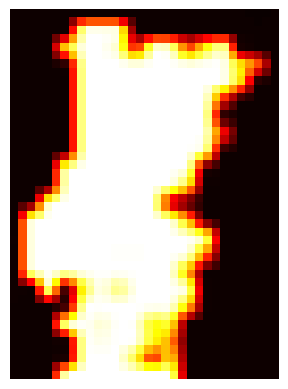

In [ ]:
#read and build the neural network
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import imageio
from scipy import ndimage



model = ConvLSTM(input_dim=4, hidden_dim=[64, 64, 4], kernel_size=(3, 3), num_layers=3, batch_first=True, bias=True, return_all_layers=False)
model.load_state_dict(torch.load('model.pth'))
model.eval()

model = model.to(device)

predicted_val = []

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(device)
    _,out = model(x)
    out = out[0][0].cpu()
    predicted_val.append(out.detach().numpy()[0])

# print heatmap each predicted_val
predicted_val = np.array(predicted_val)
print(predicted_val[0][0])
#invert the 2d

x = predicted_val[0][0]
x = rotate(x, angle=90)

plt.imshow(x, cmap='hot', interpolation='nearest')

#increase the resolution of the heatmap
new_size = (x.shape[0]*2, x.shape[1]*2)
new_img = ndimage.zoom(x, zoom=(2, 2), order=1)



plt.axis('off')
plt.imshow(new_img, cmap='hot', interpolation='nearest')
plt.savefig('test.png', transparent=False)






print(predicted_val.shape)
print(data_y_val.shape)




/tmp/ipykernel_78620/2684157384.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('heatmap.png'))


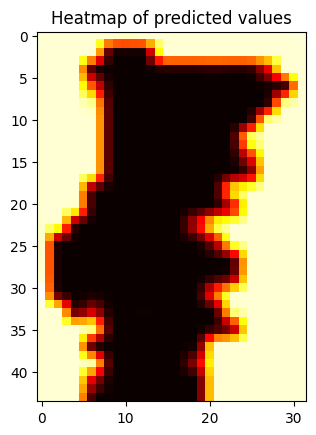

In [43]:
images = []

feature_num = 1



for i in range(0, 191):
    x = predicted_val[i][feature_num]
    x = rotate(x, angle=90)
    new_size = (x.shape[0]*2, x.shape[1]*2)
    new_img = ndimage.zoom(x, zoom=(2, 2), order=1) 
    plt.imshow(new_img, cmap='hot_r', interpolation='nearest')
    #add a colorbar
    #add a progress bar to the image of the frames
    #plt.text(0.5, 0.5, str(i), fontsize=18, ha='center')
    plt.title('Heatmap of predicted values')
    


    plt.savefig('heatmap.png')
    images.append(imageio.imread('heatmap.png'))

imageio.mimsave(f'../plots/heatmap_inv_feature{feature_num}.gif', images)